In [2]:
# Load pickled data
import pickle
import csv

# Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'
labels_file = 'signnames.csv'

input_file = csv.DictReader(open(labels_file))

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
with open(labels_file, mode='r') as f:
    reader = csv.reader(f)
    next(reader, None)
    labels_to_text = {int(rows[0]):rows[1] for rows in reader}
    
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

In [3]:
# Number of training examples
n_train = len(X_train)

#  Number of validation examples
n_validation = len(X_validation)

#  Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

#  How many unique classes/labels there are in the dataset.
n_classes = len(labels_to_text)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


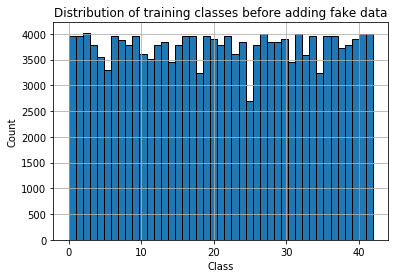

In [16]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(y_train, 43, density=0, edgecolor='black', linewidth=1)
plt.grid(True)
plt.title('Distribution of training classes before adding fake data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [17]:
import cv2
import math
import numpy as np
import random

# generate fake random training data
max_count = max(n)

new_train_x = []
new_train_y = []
for i in range(0, len(X_train)):
    label = y_train[i]
    number_of_img_to_add = math.floor(max_count * 2/n[label]) - 1    
    for t in range(0, number_of_img_to_add):
        # rotate -/+ 15 deg        
        rot_angle = random.randint(-15,15)
        M = cv2.getRotationMatrix2D((16,16),rot_angle,1)
        dst = cv2.warpAffine(X_train[i],M,(32,32))
        
        # shift horizontally and vertically -/+ 2 pixels 
        dst = np.roll(dst, random.randint(-2,2), axis=0)
        dst = np.roll(dst, random.randint(-2,2), axis=1)
        
        new_train_x.append(dst)
        new_train_y.append(label)

# add generated data to the training set
X_train = np.append(X_train, new_train_x, axis=0)
y_train = np.append(y_train, new_train_y, axis=0)

ValueError: all the input arrays must have same number of dimensions

In [ ]:
# preprocess image - convert to grayscale and normalize
def preprocess(img):
    return normalize_image(grayscale(img))

def grayscale(img):
    gr = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)   
    #gr = cv2.extractChannel(cv2.cvtColor(img, cv2.COLOR_RGB2YUV), 0)
    return np.atleast_3d(gr)

def normalize_image(image_data):
    a = 0
    b = 1
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_train = [preprocess(x) for x in X_train]
X_validation = [preprocess(x) for x in X_validation]
X_test = [preprocess(x) for x in X_test]

In [ ]:
# Shuffle the training data.
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [10]:
import tensorflow as tf

rate = 0.001
EPOCHS = 100
BATCH_SIZE = 128
KEEP_PROB = 0.25
TARGET_ACCURACY = 0.965

In [11]:
from tensorflow.contrib.layers import flatten

def LeNet(x):        
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))

    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    fc0 = flatten(conv2)    
    
    # Layer 3: Fully Connected. Input = 400. Output = 250.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 250), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(250))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    
    # Dropout layer
    fc1 = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 4: Fully Connected. Input = 250. Output = 160.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(250, 160), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(160))
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b    
    # Activation.
    fc2 = tf.nn.relu(fc2)            
    
    # Layer 5: Fully Connected. Input = 160. Output = 84.
    fc3_W = tf.Variable(tf.truncated_normal(shape=(160, 84), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(84))
    fc3 = tf.matmul(fc2, fc3_W) + fc3_b      
    # Activation.
    fc3 = tf.nn.relu(fc3)
    
    # Layer 6: Fully Connected. Input = 84. Output = 43.
    fc4_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc4_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b  
    
    return logits

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

In [13]:
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [14]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [15]:
epochs = []
train_acc_epoch = []
valid_acc_epoch = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):        
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})
                
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_validation, y_validation)
        
        epochs.append(i)
        train_acc_epoch.append(train_accuracy)
        valid_acc_epoch.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Accuracy: Training {:.3f} / Validation = {:.3f}".format(train_accuracy, validation_accuracy))
        print()
        if validation_accuracy >= TARGET_ACCURACY:
            break
        
    saver.save(sess, './traffic-v1')
    print("Model saved")

Training...

EPOCH 1 ...
Accuracy: Training 0.779 / Validation = 0.792

EPOCH 2 ...
Accuracy: Training 0.900 / Validation = 0.906

EPOCH 3 ...
Accuracy: Training 0.932 / Validation = 0.935

EPOCH 4 ...
Accuracy: Training 0.948 / Validation = 0.944

EPOCH 5 ...
Accuracy: Training 0.950 / Validation = 0.948

EPOCH 6 ...
Accuracy: Training 0.961 / Validation = 0.957



KeyboardInterrupt: 